# Goal

* Simulating fullCyc Day1 control gradients
  * Not simulating incorporation (all 0% isotope incorp.)
    * Don't know how much true incorporatation for emperical data
* Richness = genome reference pool size (n=1147)
* Simulating 10 replicate gradients to assess simulation stochasticity.
* Using a relative large bandwidth to create fairly smooth distributions

## Init

In [2]:
import os
import glob
import re
import nestly

In [3]:
%load_ext rpy2.ipython
%load_ext pushnote

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(phyloseq)

## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Want to understand how all the pieces fit together? Buy the ggplot2
book: http://ggplot2.org/book/

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


# Nestly

* assuming fragments already simulated

In [8]:
workDir = '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/'
buildDir = os.path.join(workDir, 'Day1_rep10_justOverlap')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile= '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags.pkl'
targetFile = '/home/nick/notebook/SIPSim/dev/fullCyc/CD-HIT/target_taxa.txt'

physeqDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7/phyloseq/'
physeq_bulkCore = 'bulk-core'
physeq_SIP_core = 'SIP-core_unk'

nreps = 10
prefrac_comm_abundance = '1e9'

seq_per_fraction = ['lognormal', 9.432, 0.5, 10000, 30000] # dist, mean, scale, min, max
bulk_days = [1]
nprocs = 14

In [13]:
# building tree structure
nest = nestly.Nest()

    ## varying params
nest.add('rep', [x + 1 for x in xrange(nreps)])

## set params
nest.add('bulk_day', bulk_days, create_dir=False)
nest.add('abs', [prefrac_comm_abundance], create_dir=False)
nest.add('percIncorp', [0], create_dir=False)
nest.add('percTaxa', [0], create_dir=False)
nest.add('np', [nprocs], create_dir=False)
nest.add('subsample_dist', [seq_per_fraction[0]], create_dir=False)
nest.add('subsample_mean', [seq_per_fraction[1]], create_dir=False)
nest.add('subsample_scale', [seq_per_fraction[2]], create_dir=False)
nest.add('subsample_min', [seq_per_fraction[3]], create_dir=False)
nest.add('subsample_max', [seq_per_fraction[4]], create_dir=False)
nest.add('bandwidth', [0.6], create_dir=False)
nest.add('cmd', ['"print unless /NA$/"'], create_dir=False)

### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('targetFile', [targetFile], create_dir=False)
nest.add('physeqDir', [physeqDir], create_dir=False)
nest.add('physeq_bulkCore', [physeq_bulkCore], create_dir=False)


# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [14]:
%%writefile $bashFile
#!/bin/bash

export PATH={R_dir}:$PATH

#-- making DNA pool similar to gradient of interest
echo '# Creating comm file from phyloseq'
phyloseq2comm.r {physeqDir}{physeq_bulkCore} -s 12C-Con -d {bulk_day} > {physeq_bulkCore}_comm.txt
printf 'Number of lines: '; wc -l {physeq_bulkCore}_comm.txt

echo '## Adding target taxa to comm file'
comm_add_target.r {physeq_bulkCore}_comm.txt {targetFile} > {physeq_bulkCore}_comm_target.txt
printf 'Number of lines: '; wc -l {physeq_bulkCore}_comm_target.txt

echo '## Selecting just target taxa'
perl -ne {cmd} {physeq_bulkCore}_comm_target.txt | comm_set_abund.r - > tmp.txt
rm -f {physeq_bulkCore}_comm_target.txt
mv tmp.txt {physeq_bulkCore}_comm_target.txt


echo '## parsing out genome fragments to make simulated DNA pool resembling the gradient of interest'
## all OTUs without an associated reference genome will be assigned a random reference (of the reference genome pool)
### this is done through --NA-random
SIPSim fragment_KDE_parse {fragFile} {physeq_bulkCore}_comm_target.txt \
    --rename taxon_name --NA-random > fragsParsed.pkl


echo '#-- SIPSim pipeline --#'
echo '# converting fragments to KDE'
SIPSim fragment_KDE \
    fragsParsed.pkl \
    > fragsParsed_KDE.pkl
    
echo '# adding diffusion'
SIPSim diffusion \
    fragsParsed_KDE.pkl \
    --bw {bandwidth} \
    --np {np} \
    > fragsParsed_KDE_dif.pkl    

echo '# adding DBL contamination'
SIPSim DBL \
    fragsParsed_KDE_dif.pkl \
    --bw {bandwidth} \
    --np {np} \
    > fragsParsed_KDE_dif_DBL.pkl      
    
echo '# making incorp file'
SIPSim incorpConfigExample \
  --percTaxa {percTaxa} \
  --percIncorpUnif {percIncorp} \
  > {percTaxa}_{percIncorp}.config

echo '# adding isotope incorporation to BD distribution'
SIPSim isotope_incorp \
    fragsParsed_KDE_dif_DBL.pkl \
    {percTaxa}_{percIncorp}.config \
    --comm {physeq_bulkCore}_comm_target.txt \
    --bw {bandwidth} \
    --np {np} \
    > fragsParsed_KDE_dif_DBL_inc.pkl
    

echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    {physeq_bulkCore}_comm_target.txt \
    > fracs.txt 

echo '# simulating an OTU table'
SIPSim OTU_table \
    fragsParsed_KDE_dif_DBL_inc.pkl \
    {physeq_bulkCore}_comm_target.txt \
    fracs.txt \
    --abs {abs} \
    --np {np} \
    > OTU_abs{abs}.txt
    
#echo '# simulating PCR'
#SIPSim OTU_PCR \
#    OTU_abs{abs}.txt \
#    > OTU_abs{abs}_PCR.txt    
    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_sub.txt
        
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_sub.txt \
    > OTU_abs{abs}_sub_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_sub.txt \
    > OTU_abs{abs}_sub_meta.txt

Writing /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/SIPSimRun.sh


In [ ]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun  --template-file $bashFile -d Day1_rep10_justOverlap --log-file log.txt -j 2

2016-02-08 19:54:42,420 * INFO * Template: ./SIPSimRun.sh
2016-02-08 19:54:42,422 * INFO * [68129] Started ./SIPSimRun.sh in Day1_rep10_justOverlap/7
2016-02-08 19:54:42,423 * INFO * [68130] Started ./SIPSimRun.sh in Day1_rep10_justOverlap/9
2016-02-08 20:04:19,046 * INFO * [68130] Day1_rep10_justOverlap/9 Finished with 0
2016-02-08 20:04:19,047 * INFO * [68989] Started ./SIPSimRun.sh in Day1_rep10_justOverlap/8
2016-02-08 20:04:22,596 * INFO * [68129] Day1_rep10_justOverlap/7 Finished with 0
2016-02-08 20:04:22,597 * INFO * [69041] Started ./SIPSimRun.sh in Day1_rep10_justOverlap/3
2016-02-08 20:13:29,167 * INFO * [68989] Day1_rep10_justOverlap/8 Finished with 0
2016-02-08 20:13:29,169 * INFO * [70289] Started ./SIPSimRun.sh in Day1_rep10_justOverlap/10
2016-02-08 20:13:36,733 * INFO * [69041] Day1_rep10_justOverlap/3 Finished with 0
2016-02-08 20:13:36,735 * INFO * [70367] Started ./SIPSimRun.sh in Day1_rep10_justOverlap/2


# BD min/max

* what is the min/max BD that we care about?

In [17]:
%%R
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

cat('Min BD:', min_BD, '\n')
cat('Max BD:', max_BD, '\n')

Min BD: 1.67323 
Max BD: 1.7744 


# Loading data

## Emperical

### SIP data

In [18]:
%%R 
# simulated OTU table file
OTU.table.dir = '/home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5/Day1_default_run/1e9/'
OTU.table.file = 'OTU_abs1e9_PCR_sub.txt'
#OTU.table.file = 'OTU_abs1e9_sub.txt'
#OTU.table.file = 'OTU_abs1e9.txt'

In [19]:
%%R -i physeqDir -i physeq_SIP_core -i bulk_days

# bulk core samples
F = file.path(physeqDir, physeq_SIP_core)
physeq.SIP.core = readRDS(F) 
physeq.SIP.core.m = physeq.SIP.core %>% sample_data

physeq.SIP.core = prune_samples(physeq.SIP.core.m$Substrate == '12C-Con' & 
                                physeq.SIP.core.m$Day %in% bulk_days, 
                                physeq.SIP.core) %>%
    filter_taxa(function(x) sum(x) > 0, TRUE)
physeq.SIP.core.m = physeq.SIP.core %>% sample_data        

physeq.SIP.core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7025 taxa and 25 samples ]
sample_data() Sample Data:       [ 25 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 7025 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7025 tips and 7024 internal nodes ]


In [20]:
%%R 
## dataframe
df.EMP = physeq.SIP.core %>% otu_table %>%
    as.matrix %>% as.data.frame
df.EMP$OTU = rownames(df.EMP)
df.EMP = df.EMP %>%    
    gather(sample, abundance, 1:(ncol(df.EMP)-1)) 

df.EMP = inner_join(df.EMP, physeq.SIP.core.m, c('sample' = 'X.Sample')) 

df.EMP.nt = df.EMP %>%
    group_by(sample) %>%
    mutate(n_taxa = sum(abundance > 0)) %>%
    ungroup() %>%
    distinct(sample) %>%
    filter(Buoyant_density >= min_BD, 
           Buoyant_density <= max_BD)
    
df.EMP.nt %>% head(n=3)

Source: local data frame [3 x 20]

       OTU            sample abundance primer_number fwd_barcode rev_barcode
     (chr)             (chr)     (dbl)         (int)      (fctr)      (fctr)
1 OTU.1101 12C-Con.D1.R2_F23         2           134    TCGACGAG    TGAGTACG
2 OTU.1101 12C-Con.D1.R2_F18         0           129    CTACTATA    TGAGTACG
3 OTU.1101 12C-Con.D1.R2_F20         1           131    AGAGTCAC    TGAGTACG
Variables not shown: Substrate (fctr), Day (int), Microcosm_replicate (int),
  Fraction (int), Buoyant_density (dbl), Sample_type (fctr), library (fctr),
  Exp_type (fctr), Sample_location (lgl), Sample_date (lgl), Sample_treatment
  (lgl), Sample_subtreatment (lgl), core_dataset (lgl), n_taxa (int)


### bulk soil samples

In [21]:
%%R
physeq.dir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7/phyloseq/'
physeq.bulk = 'bulk-core'
physeq.file = file.path(physeq.dir, physeq.bulk)
physeq.bulk = readRDS(physeq.file)
physeq.bulk.m = physeq.bulk %>% sample_data
physeq.bulk = prune_samples(physeq.bulk.m$Exp_type == 'microcosm_bulk' &
                            physeq.bulk.m$Day %in% bulk_days, physeq.bulk)

physeq.bulk.m = physeq.bulk %>% sample_data
physeq.bulk

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4950 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 4950 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4950 tips and 4949 internal nodes ]


In [22]:
%%R
physeq.bulk.n = transform_sample_counts(physeq.bulk, function(x) x/sum(x))
physeq.bulk.n

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4950 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 4950 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4950 tips and 4949 internal nodes ]


In [23]:
%%R
# making long format of each bulk table
bulk.otu = physeq.bulk.n %>% otu_table %>% as.data.frame
ncol = ncol(bulk.otu)
bulk.otu$OTU = rownames(bulk.otu)
bulk.otu = bulk.otu %>%
    gather(sample, abundance, 1:ncol) 

bulk.otu = inner_join(physeq.bulk.m, bulk.otu, c('X.Sample' = 'sample')) %>%
    dplyr::select(OTU, abundance) %>%
    rename('bulk_abund' = abundance)
bulk.otu %>% head(n=3)

       OTU   bulk_abund
1 OTU.1101 1.234263e-04
2 OTU.1130 6.171316e-05
3 OTU.9833 0.000000e+00


In [24]:
%%R
# joining tables
df.EMP.j = inner_join(df.EMP, bulk.otu, c('OTU' = 'OTU')) %>%
    filter(Buoyant_density >= min_BD, 
           Buoyant_density <= max_BD) 
    
df.EMP.j %>% head(n=3)

       OTU            sample abundance primer_number fwd_barcode rev_barcode
1 OTU.1101 12C-Con.D1.R2_F23         2           134    TCGACGAG    TGAGTACG
2 OTU.1130 12C-Con.D1.R2_F23         0           134    TCGACGAG    TGAGTACG
3 OTU.9833 12C-Con.D1.R2_F23         0           134    TCGACGAG    TGAGTACG
  Substrate Day Microcosm_replicate Fraction Buoyant_density Sample_type
1   12C-Con   1                   2       23         1.69362     unknown
2   12C-Con   1                   2       23         1.69362     unknown
3   12C-Con   1                   2       23         1.69362     unknown
         library Exp_type Sample_location Sample_date Sample_treatment
1 150721_V4_Lib4      SIP              NA          NA               NA
2 150721_V4_Lib4      SIP              NA          NA               NA
3 150721_V4_Lib4      SIP              NA          NA               NA
  Sample_subtreatment core_dataset   bulk_abund
1                  NA         TRUE 1.234263e-04
2                  N

## Simulated

In [25]:
OTU_files = !find $buildDir -name "OTU_abs1e9_sub.txt"
OTU_files

['/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/7/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/9/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/8/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/3/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/10/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/2/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/1/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/4/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/5/OTU_abs1e9_s

In [26]:
%%R -i OTU_files
# loading files

df.SIM = list()
for (x in OTU_files){
    SIM_rep = gsub('/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/', '', x)
    SIM_rep = gsub('/OTU_abs1e9_sub.txt', '', SIM_rep)
    df.SIM[[SIM_rep]] = read.delim(x, sep='\t') 
    }
df.SIM = do.call('rbind', df.SIM)
df.SIM$SIM_rep = gsub('\\.[0-9]+$', '', rownames(df.SIM))
rownames(df.SIM) = 1:nrow(df.SIM)
df.SIM %>% head

  library    fraction taxon BD_min BD_mid BD_max count  rel_abund SIM_rep
1       1  -inf-1.660 OTU.1   -Inf  1.659  1.659  1149 0.09454456       7
2       1 1.660-1.664 OTU.1  1.660  1.662  1.664  1630 0.13861723       7
3       1 1.664-1.669 OTU.1  1.664  1.667  1.669  2883 0.13190886       7
4       1 1.669-1.673 OTU.1  1.669  1.671  1.673  1612 0.11300386       7
5       1 1.673-1.676 OTU.1  1.673  1.675  1.676  1378 0.09448063       7
6       1 1.676-1.681 OTU.1  1.676  1.679  1.681   321 0.03165993       7


In [27]:
%%R
## edit table
df.SIM.nt = df.SIM %>%
    filter(count > 0) %>%
    group_by(SIM_rep, library, BD_mid) %>%
    summarize(n_taxa = n()) %>%
    filter(BD_mid >= min_BD, 
           BD_mid <= max_BD)
df.SIM.nt %>% head    

Source: local data frame [6 x 4]
Groups: SIM_rep, library [1]

  SIM_rep library BD_mid n_taxa
    (chr)   (int)  (dbl)  (int)
1       1       1  1.676     88
2       1       1  1.682     67
3       1       1  1.686     48
4       1       1  1.689     41
5       1       1  1.692     35
6       1       1  1.696     66


### 'bulk soil' community files

In [28]:
# loading comm files
comm_files = !find $buildDir -name "bulk-core_comm_target.txt"
comm_files

['/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/7/bulk-core_comm_target.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/9/bulk-core_comm_target.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/8/bulk-core_comm_target.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/3/bulk-core_comm_target.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/10/bulk-core_comm_target.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/2/bulk-core_comm_target.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/1/bulk-core_comm_target.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/4/bulk-core_comm_target.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_

In [29]:
%%R -i comm_files

df.comm = list()
for (f in comm_files){
    rep = gsub('.+/Day1_rep10_justOverlap/([0-9]+)/.+', '\\1', f)
    df.comm[[rep]] = read.delim(f, sep='\t') %>%
        dplyr::select(library, taxon_name, rel_abund_perc) %>%
        rename('bulk_abund' = rel_abund_perc) %>%
        mutate(bulk_abund = bulk_abund / 100)
}

df.comm = do.call('rbind', df.comm)
df.comm$SIM_rep = gsub('\\.[0-9]+$', '', rownames(df.comm))
rownames(df.comm) = 1:nrow(df.comm)
df.comm %>% head(n=3)

  library taxon_name bulk_abund SIM_rep
1       1      OTU.2  0.2562787       7
2       1      OTU.1  0.1226033       7
3       1      OTU.5  0.1188226       7


In [30]:
%%R
## joining tables
df.SIM.j = inner_join(df.SIM, df.comm, c('SIM_rep' = 'SIM_rep',
                                         'library' = 'library',
                                         'taxon' = 'taxon_name')) %>%
    filter(BD_mid >= min_BD, 
           BD_mid <= max_BD)
    
df.SIM.j %>% head(n=3)

  library    fraction taxon BD_min BD_mid BD_max count  rel_abund SIM_rep
1       1 1.673-1.676 OTU.1  1.673  1.675  1.676  1378 0.09448063       7
2       1 1.676-1.681 OTU.1  1.676  1.679  1.681   321 0.03165993       7
3       1 1.681-1.683 OTU.1  1.681  1.682  1.683   127 0.01081035       7
  bulk_abund
1  0.1226033
2  0.1226033
3  0.1226033


In [31]:
%%R 
# filtering & combining emperical w/ simulated data

## emperical 
max_BD_range = max(df.EMP.j$Buoyant_density) - min(df.EMP.j$Buoyant_density)
df.EMP.j.f = df.EMP.j %>%
    filter(abundance > 0) %>%
    group_by(OTU) %>%
    summarize(mean_rel_abund = mean(bulk_abund),
              min_BD = min(Buoyant_density),
              max_BD = max(Buoyant_density),
              BD_range = max_BD - min_BD,
              BD_range_perc = BD_range / max_BD_range * 100) %>%
    ungroup() %>%
    mutate(dataset = 'emperical',
           SIM_rep = NA)

## simulated
max_BD_range = max(df.SIM.j$BD_mid) - min(df.SIM.j$BD_mid)
df.SIM.j.f = df.SIM.j %>%
    filter(count > 0) %>%
    group_by(SIM_rep, taxon) %>%
    summarize(mean_rel_abund = mean(bulk_abund),
              min_BD = min(BD_mid),
              max_BD = max(BD_mid),
              BD_range = max_BD - min_BD,
              BD_range_perc = BD_range / max_BD_range * 100) %>%
    ungroup() %>%
    rename('OTU' = taxon) %>%
    mutate(dataset = 'simulated')

## join
df.j = rbind(df.EMP.j.f, df.SIM.j.f) %>%
    filter(BD_range_perc > 0,
            mean_rel_abund > 0)

df.j$SIM_rep = reorder(df.j$SIM_rep, df.j$SIM_rep %>% as.numeric)

df.j %>% head(n=3)

Source: local data frame [3 x 8]

      OTU mean_rel_abund   min_BD   max_BD   BD_range BD_range_perc   dataset
    (chr)          (dbl)    (dbl)    (dbl)      (dbl)         (dbl)     (chr)
1   OTU.1    0.028017773 1.676135 1.773391 0.09725564           100 emperical
2  OTU.10    0.001172550 1.676135 1.773391 0.09725564           100 emperical
3 OTU.100    0.001049124 1.676135 1.773391 0.09725564           100 emperical
Variables not shown: SIM_rep (fctr)


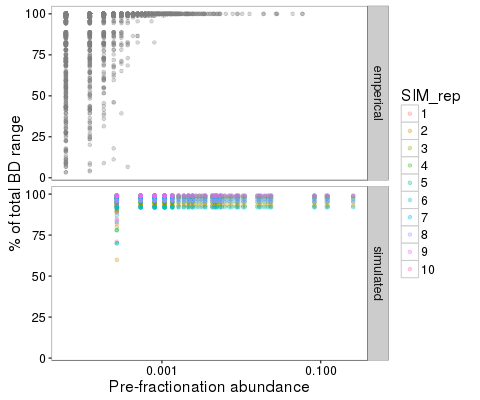

In [32]:
%%R -h 400
## plotting
ggplot(df.j, aes(mean_rel_abund, BD_range_perc, color=SIM_rep)) +
    geom_point(alpha=0.3) +
    scale_x_log10() +
    scale_y_continuous() +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    facet_grid(dataset ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid = element_blank()#,
        #legend.position = 'none'
        )


## BD span of just overlapping taxa (redundant; but consistent wiht other notebooks)

* Taxa overlapping between emperical data and genomes in dataset
* These taxa should have the same relative abundances in both datasets.
  * The comm file was created from the emperical dataset phyloseq file.

In [33]:
%%R -i targetFile

df.target = read.delim(targetFile, sep='\t')
df.target %>% nrow %>% print
df.target %>% head(n=3)

[1] 194
  cluster
1     212
2     762
3     663
                                                                                                   ssu_ID
1          rRNA_NC_014259_Acinetobacter_oleivorans_DR1__Acinetobacter_oleivorans_DR1_3479770-3481295_DIR-
2 rRNA_NC_019973_Mesorhizobium_australicum_WSM2073__Mesorhizobium_australicum_WSM207_1746046-1747518_DIR+
3  rRNA_NC_013037_Dyadobacter_fermentans_DSM_18053__Dyadobacter_fermentans_DSM_18053_4003859-4005353_DIR-
                                                                                         genome_fileID
1      /var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/Acinetobacter_oleivorans_DR1.fna
2 /var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/Mesorhizobium_australicum_WSM2073.fna
3  /var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/Dyadobacter_fermentans_DSM_18053.fna
                           genomeID
1      Acinetobacter_oleivorans_DR1
2 Mesorhizobium_australicum_WSM2073
3  Dyado

[1] 2794
[1] 1014


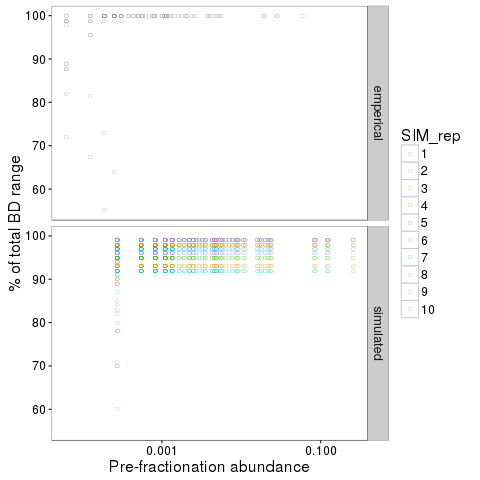

In [34]:
%%R
# filtering to just target taxa
df.j.t = df.j %>% 
    filter(OTU %in% df.target$OTU) 
df.j %>% nrow %>% print
df.j.t %>% nrow %>% print

## plotting
ggplot(df.j.t, aes(mean_rel_abund, BD_range_perc, color=SIM_rep)) +
    geom_point(alpha=0.5, shape='O') +
    scale_x_log10() +
    scale_y_continuous() +
    #scale_color_manual(values=c('blue', 'red')) +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    facet_grid(dataset ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid = element_blank()#,
        #legend.position = 'none'
        )

### Check 

* Are all target (overlapping) taxa the same relative abundances in both datasets?

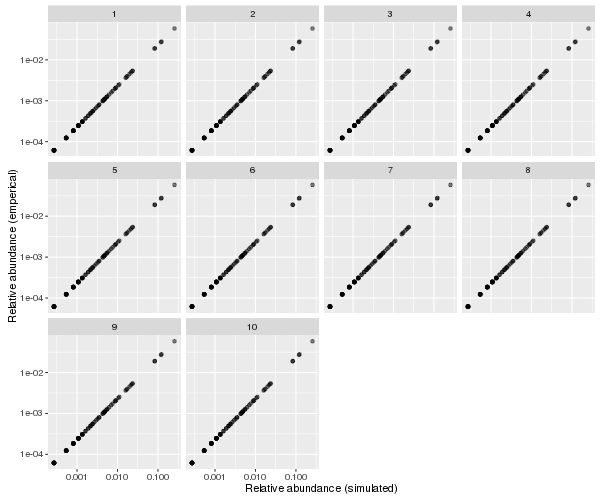

In [35]:
%%R -w 600 -h 500
# formatting data
df.1 = df.j.t %>% 
    filter(dataset == 'simulated') %>%
    select(SIM_rep, OTU, mean_rel_abund, BD_range, BD_range_perc)

df.2 = df.j.t %>%
    filter(dataset == 'emperical') %>%
    select(SIM_rep, OTU, mean_rel_abund, BD_range, BD_range_perc)

df.12 = inner_join(df.1, df.2, c('OTU' = 'OTU')) %>%
    mutate(BD_diff_perc = BD_range_perc.y - BD_range_perc.x)


df.12$SIM_rep.x = reorder(df.12$SIM_rep.x, df.12$SIM_rep.x  %>% as.numeric)

## plotting
p1 = ggplot(df.12, aes(mean_rel_abund.x, mean_rel_abund.y)) +
    geom_point(alpha=0.5) +
    scale_x_log10() +
    scale_y_log10() +
    labs(x='Relative abundance (simulated)', y='Relative abundance (emperical)') +
    facet_wrap(~ SIM_rep.x)
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid = element_blank(),
        legend.position = 'none'
        )
p1

### Correlation between relative abundance and BD_range diff

* Are low abundant taxa more variable in their BD span

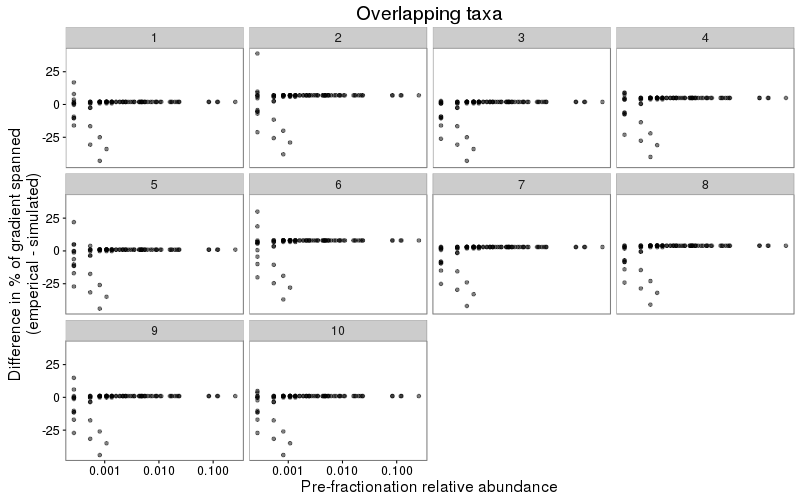

In [36]:
%%R -w 800 -h 500

ggplot(df.12, aes(mean_rel_abund.x, BD_diff_perc)) +
    geom_point(alpha=0.5) +
    scale_x_log10() +
    labs(x='Pre-fractionation relative abundance', 
         y='Difference in % of gradient spanned\n(emperical - simulated)',
         title='Overlapping taxa') +
    facet_wrap(~ SIM_rep.x) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid = element_blank(),
        legend.position = 'none'
        )


#### Notes

* between Day1_rep10, Day1_richFromTarget_rep10, and Day1_add_Rich_rep10:
  * Day1_rep10 has the most accurate representation of BD span (% of gradient spanned by taxa).
    * Accuracy drops at ~1e-3 to ~5e-4, but this is caused by detection limits (veil-line effect).

# Comparing abundance distributions of overlapping taxa

In [37]:
%%R

join_abund_dists = function(df.EMP.j, df.SIM.j, df.target){
    ## emperical 
    df.EMP.j.f = df.EMP.j %>%
        filter(abundance > 0) %>%
        dplyr::select(OTU, sample, abundance, Buoyant_density, bulk_abund) %>%
        mutate(dataset = 'emperical', SIM_rep = NA) %>%
        filter(OTU %in% df.target$OTU) 
    
    ## simulated
    df.SIM.j.f = df.SIM.j %>%
        filter(count > 0) %>%
        dplyr::select(taxon, fraction, count, BD_mid, bulk_abund, SIM_rep) %>%
        rename('OTU' = taxon,
               'sample' = fraction,
               'Buoyant_density' = BD_mid,
               'abundance' = count) %>%
        mutate(dataset = 'simulated') %>%
        filter(OTU %in% df.target$OTU) 
    
    ## getting just intersecting OTUs
    OTUs.int = intersect(df.EMP.j.f$OTU, df.SIM.j.f$OTU)
    
    df.j = rbind(df.EMP.j.f, df.SIM.j.f) %>%
        filter(OTU %in% OTUs.int) %>%
        group_by(sample) %>%
        mutate(rel_abund = abundance / sum(abundance))
    
    cat('Number of overlapping OTUs between emperical & simulated:', 
            df.j$OTU %>% unique %>% length, '\n\n')
    return(df.j)
    }


df.j = join_abund_dists(df.EMP.j, df.SIM.j, df.target)
df.j %>% head(n=3) %>% as.data.frame                  

Number of overlapping OTUs between emperical & simulated: 92 

      OTU            sample abundance Buoyant_density   bulk_abund   dataset
1 OTU.170 12C-Con.D1.R2_F23         2         1.69362 0.0005554184 emperical
2  OTU.24 12C-Con.D1.R2_F23        25         1.69362 0.0020982473 emperical
3  OTU.11 12C-Con.D1.R2_F23         4         1.69362 0.0004319921 emperical
  SIM_rep    rel_abund
1    <NA> 0.0006006006
2    <NA> 0.0075075075
3    <NA> 0.0012012012


In [38]:
%%R
# closure operation
df.j = df.j %>%
    ungroup() %>%
    mutate(SIM_rep = SIM_rep %>% as.numeric) %>%
    group_by(dataset, SIM_rep, sample) %>%
    mutate(rel_abund_c = rel_abund / sum(rel_abund)) %>%
    ungroup()

df.j %>% head(n=3) %>% as.data.frame

      OTU            sample abundance Buoyant_density   bulk_abund   dataset
1 OTU.170 12C-Con.D1.R2_F23         2         1.69362 0.0005554184 emperical
2  OTU.24 12C-Con.D1.R2_F23        25         1.69362 0.0020982473 emperical
3  OTU.11 12C-Con.D1.R2_F23         4         1.69362 0.0004319921 emperical
  SIM_rep    rel_abund  rel_abund_c
1      NA 0.0006006006 0.0006006006
2      NA 0.0075075075 0.0075075075
3      NA 0.0012012012 0.0012012012


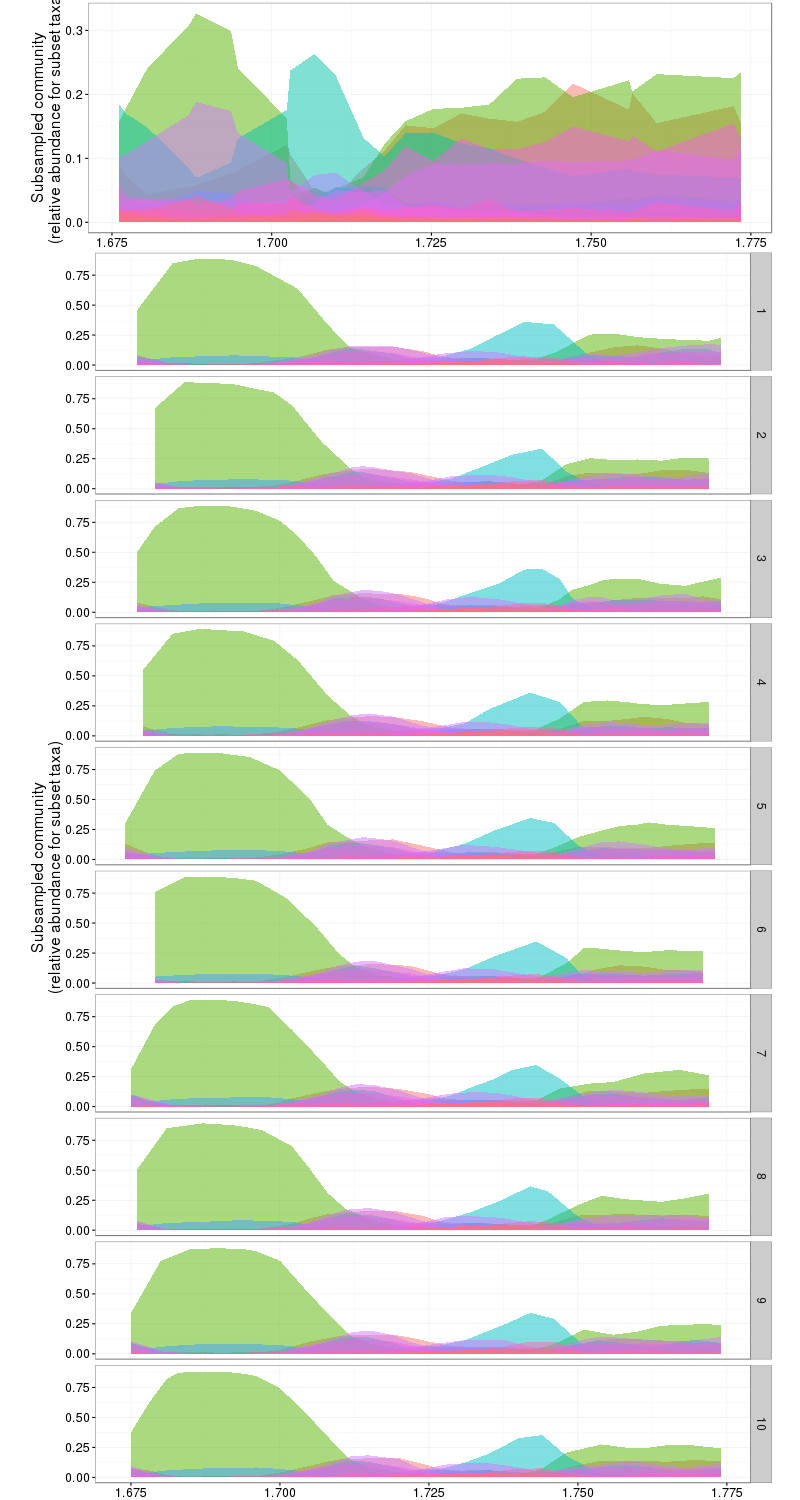

In [39]:
%%R -h 1500 -w 800
# plotting 
plot_abunds = function(df){
    p = ggplot(df, aes(Buoyant_density, rel_abund_c, fill=OTU)) +
        geom_area(stat='identity', position='dodge', alpha=0.5) +
        labs(x='Buoyant density', 
             y='Subsampled community\n(relative abundance for subset taxa)') +
        theme_bw() +
        theme( 
            text = element_text(size=16),
            legend.position = 'none',
              axis.title.y = element_text(vjust=1),        
              axis.title.x = element_blank(),
              plot.margin=unit(c(0.1,1,0.1,1), "cm")
             )
    return(p)
    }


# simulations
df.j.f = df.j %>%
    filter(dataset == 'simulated')
p.SIM = plot_abunds(df.j.f)
p.SIM = p.SIM + facet_grid(SIM_rep ~ .)

# emperical
df.j.f = df.j %>%
    filter(dataset == 'emperical')
p.EMP = plot_abunds(df.j.f)

# make figure
grid.arrange(p.EMP, p.SIM, ncol=1, heights=c(1,5))

## Check: plotting closure abs-abunds of overlapping taxa

* The overlapping taxa should have the same closure-transformed relative abundances for both:
  * absolute abundances (OTU table)
  * relative abundances (subsampled OTU table; as above)

### Loading OTU table (abs abunds)

In [40]:
OTU_files = !find $buildDir -name "OTU_abs1e9.txt"
OTU_files

['/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/7/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/9/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/8/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/3/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/10/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/2/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/1/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/4/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/5/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSi

In [41]:
%%R -i OTU_files
# loading files

df.SIM.abs = list()
for (x in OTU_files){
    SIM_rep = gsub('/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10/', '', x)
    SIM_rep = gsub('/OTU_abs1e9.txt', '', SIM_rep)
    df.SIM.abs[[SIM_rep]] = read.delim(x, sep='\t') 
    }
df.SIM.abs = do.call('rbind', df.SIM.abs)
df.SIM.abs$SIM_rep = gsub('\\.[0-9]+$', '', rownames(df.SIM.abs))
rownames(df.SIM.abs) = 1:nrow(df.SIM.abs)
df.SIM.abs %>% head

  library taxon    fraction BD_min BD_mid BD_max count  rel_abund
1       1 OTU.1  -inf-1.660   -Inf  1.659  1.659  6026 0.09472013
2       1 OTU.1 1.660-1.664  1.660  1.662  1.664  3850 0.14242906
3       1 OTU.1 1.664-1.669  1.664  1.667  1.669  4876 0.13289725
4       1 OTU.1 1.669-1.673  1.669  1.671  1.673  3529 0.11204953
5       1 OTU.1 1.673-1.676  1.673  1.675  1.676  2510 0.09758563
6       1 OTU.1 1.676-1.681  1.676  1.679  1.681  3442 0.03239468
                                                                                   SIM_rep
1 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/7
2 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/7
3 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/7
4 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/7
5 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOv

In [42]:
%%R
# subset just overlapping taxa
# & closure operation
df.SIM.abs.t = df.SIM.abs %>%
    filter(taxon %in% df.target$OTU) %>%
    group_by(SIM_rep, fraction) %>%
    mutate(rel_abund_c = count / sum(count)) %>%
    rename('Buoyant_density' = BD_mid,
           'OTU' = taxon)

df.SIM.abs.t %>% head(n=3) %>% as.data.frame

  library   OTU    fraction BD_min Buoyant_density BD_max count  rel_abund
1       1 OTU.1  -inf-1.660   -Inf           1.659  1.659  6026 0.09472013
2       1 OTU.1 1.660-1.664  1.660           1.662  1.664  3850 0.14242906
3       1 OTU.1 1.664-1.669  1.664           1.667  1.669  4876 0.13289725
                                                                                   SIM_rep
1 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/7
2 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/7
3 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/7
  rel_abund_c
1  0.09472013
2  0.14242906
3  0.13289725


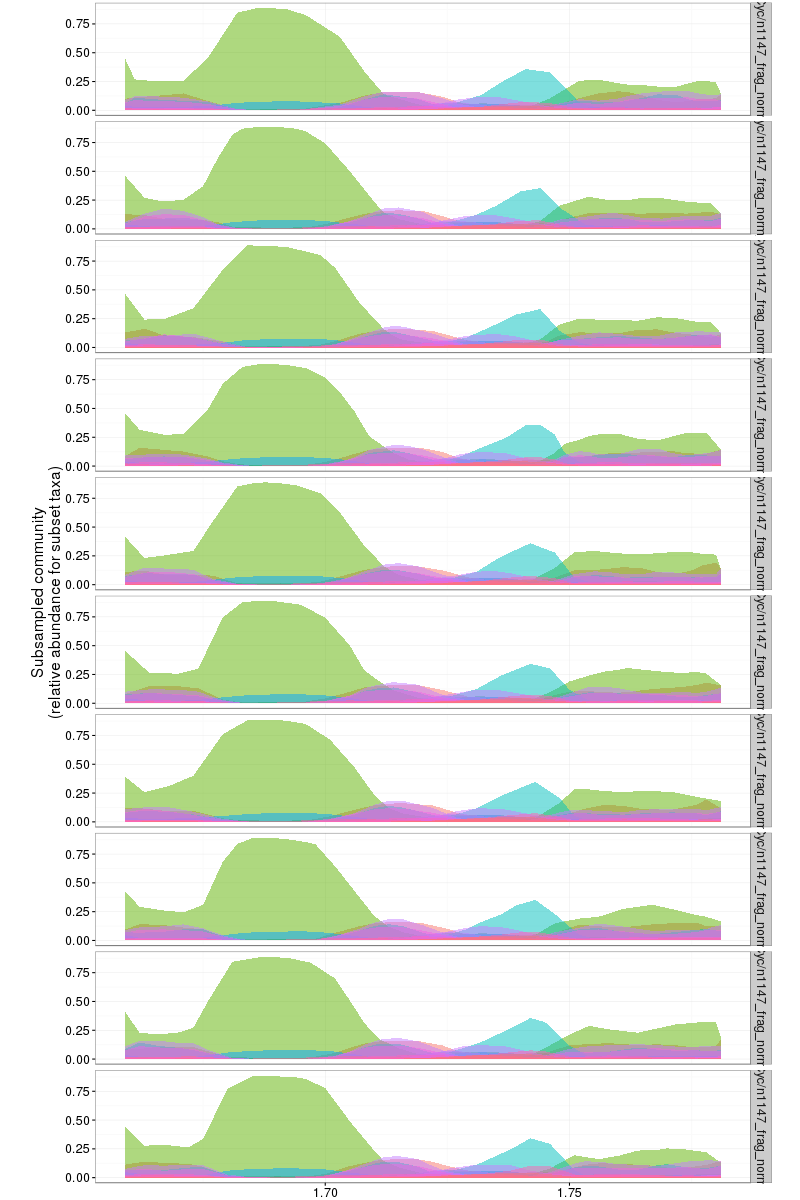

In [43]:
%%R -w 800 -h 1200
# plotting
p.abs = plot_abunds(df.SIM.abs.t) 
p.abs + facet_grid(SIM_rep ~ .)

#### Notes

* The abundance distributions of the overlapping OTUs look pretty similar between 'absolute' and 'relative' (post-PCR & post-sequencing simulation). 
  * The difference between absolute and relative are probably due to the PCR simulation

# Calculating center of mass for overlapping taxa

* weighted mean BD, where weights are relative abundances

In [44]:
%%R

center_mass = function(df){
    df = df %>%
        group_by(dataset, SIM_rep, OTU) %>%
        summarize(center_mass = weighted.mean(Buoyant_density, rel_abund_c, na.rm=T)) %>%
        ungroup()
    return(df)
}

df.j.cm = center_mass(df.j) 

Number of OTUs: 92 


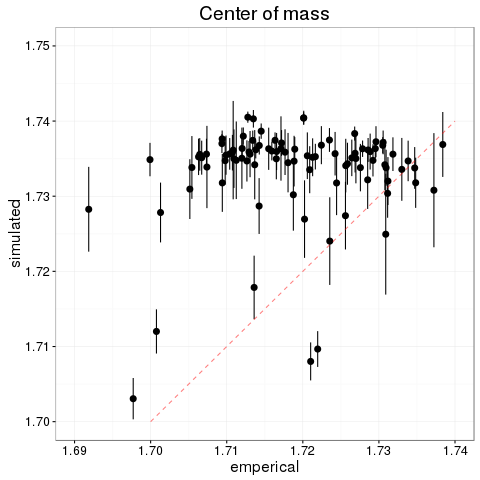

In [45]:
%%R
# getting mean cm for all SIM_reps
df.j.cm.s = df.j.cm %>%
    group_by(dataset, OTU) %>%
    summarize(mean_cm = mean(center_mass, na.rm=T),
              stdev_cm = sd(center_mass)) %>%
    ungroup() %>%
    spread(dataset, mean_cm) %>%
    group_by(OTU) %>%
    summarize(stdev_cm = mean(stdev_cm, na.rm=T),
              emperical = mean(emperical, na.rm=T),
              simulated = mean(simulated, na.rm=T)) %>%
    ungroup()

# check
cat('Number of OTUs:', df.j.cm.s$OTU %>% unique %>% length, '\n')

# plotting
ggplot(df.j.cm.s, aes(emperical, simulated,
                    ymin = simulated - stdev_cm,
                    ymax = simulated + stdev_cm)) +
    geom_pointrange() +
    stat_function(fun = function(x) x, linetype='dashed', alpha=0.5, color='red') +
    scale_x_continuous(limits=c(1.69, 1.74)) +
    scale_y_continuous(limits=c(1.7, 1.75)) +
    labs(title='Center of mass') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

#### Notes

* Error bars are stdev of simulation reps
* The center of mass for most OTUs is shifted heavier in the simulations vs the emperical data
* Also, most have a mean simulated BD of ~1.73
  * This is approximately the middle of the BD range (1.725)
  * It suggests that many of the taxa are equally dispersed across the gradient

In [46]:
%%R
BD_MIN = df.j$Buoyant_density %>% min 
BD_MAX = df.j$Buoyant_density %>% max
BD_AVE = mean(c(BD_MIN, BD_MAX))
print(c(BD_MIN, BD_AVE, BD_MAX))

[1] 1.674 1.724 1.774


## R^2 for each SIM_rep

In [47]:
%%R
# formatting table
df.j.cm.j = inner_join(df.j.cm %>% 
                           filter(dataset == 'simulated') %>%
                           rename('cm_SIM' = center_mass),
                       df.j.cm %>% 
                           filter(dataset == 'emperical') %>%
                           rename('cm_EMP' = center_mass),
                       c('OTU' = 'OTU')) %>%
    select(-starts_with('dataset'))

df.j.cm.j %>% head

Source: local data frame [6 x 5]

  SIM_rep.x      OTU   cm_SIM SIM_rep.y   cm_EMP
      (dbl)    (chr)    (dbl)     (dbl)    (dbl)
1         1    OTU.1 1.738319        NA 1.730945
2         1 OTU.1000 1.736823        NA 1.729528
3         1 OTU.1022 1.738273        NA 1.720226
4         1  OTU.106 1.738510        NA 1.712178
5         1   OTU.11 1.737279        NA 1.730503
6         1  OTU.113 1.736445        NA 1.715515


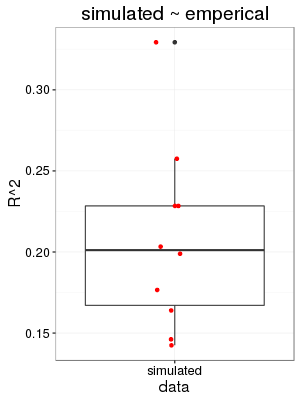

In [48]:
%%R -w 300 -h 400
# lm()
df.j.cm.j.lm = df.j.cm.j %>%
    group_by(SIM_rep.x) %>%
    do(fit = lm(cm_EMP ~ cm_SIM, data = .)) %>%
    mutate(R2 =  summary(fit)$coeff[2],
           data = 'simulated')

#df.j.cm.j.lm %>% head

# plotting
ggplot(df.j.cm.j.lm, aes(data, R2)) +
    geom_boxplot() +
    geom_jitter(height=0, width=0.2, color='red') +
    labs(y='R^2', title='simulated ~ emperical') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )


#### Notes:

* Pretty low R^2, with 1 simulation rep at almost 0

## Plotting abundances of taxa that show good agreement between datasets

[1] "OTUs:"
 [1] "OTU.1"    "OTU.1000" "OTU.1022" "OTU.11"   "OTU.116"  "OTU.12"  
 [7] "OTU.1269" "OTU.1466" "OTU.1538" "OTU.16"   "OTU.179"  "OTU.208" 
[13] "OTU.232"  "OTU.24"   "OTU.240"  "OTU.274"  "OTU.29"   "OTU.30"  
[19] "OTU.308"  "OTU.33"   "OTU.3726" "OTU.3798" "OTU.40"   "OTU.400" 
[25] "OTU.4114" "OTU.493"  "OTU.6"    "OTU.67"   "OTU.69"   "OTU.710" 
[31] "OTU.838"  "OTU.89"   "OTU.894" 


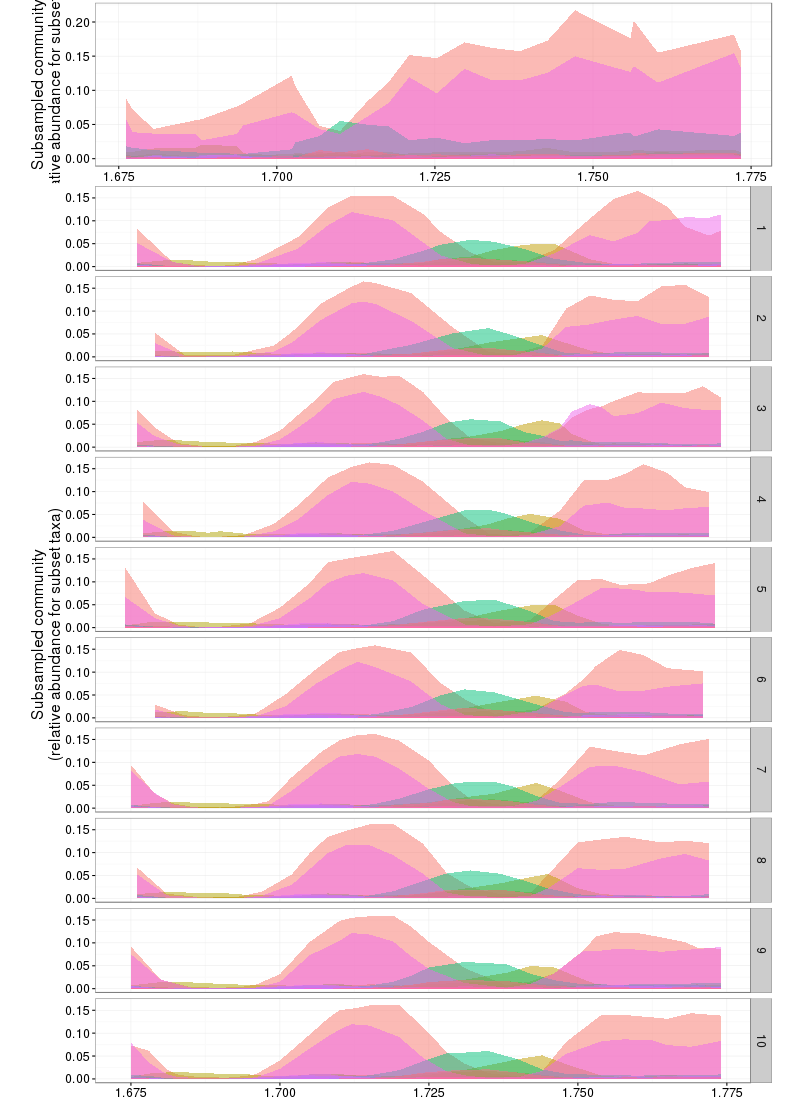

In [55]:
%%R -h 1100 -w 800

# cutoff on which OTU are major outliers (varying between simulated and emperical)
BD.diff.cut = 0.01

# which OTU to plot?
df.j.cm.s.f = df.j.cm.s %>% 
    mutate(cm_diff = abs(emperical - simulated)) %>%
    filter(cm_diff <= BD.diff.cut, ! is.na(simulated)) 

print('OTUs:')
print(df.j.cm.s.f$OTU)

# filtering to just target taxon
## Simulated
df.j.f = df.j %>%
    filter(dataset == 'simulated', 
           OTU %in% df.j.cm.s.f$OTU) 

p.SIM = plot_abunds(df.j.f)
p.SIM = p.SIM + facet_grid(SIM_rep ~ .)

## Emperical
df.j.f = df.j %>%
    filter(dataset == 'emperical', 
           OTU %in% df.j.cm.s.f$OTU)
p.EMP = plot_abunds(df.j.f)

# make figure
grid.arrange(p.EMP, p.SIM, ncol=1, heights=c(1,5))

[1] "OTUs:"
 [1] "OTU.106"  "OTU.113"  "OTU.119"  "OTU.121"  "OTU.1275" "OTU.146" 
 [7] "OTU.149"  "OTU.15"   "OTU.170"  "OTU.18"   "OTU.198"  "OTU.22"  
[13] "OTU.224"  "OTU.226"  "OTU.264"  "OTU.2746" "OTU.2955" "OTU.2978"
[19] "OTU.3"    "OTU.31"   "OTU.32"   "OTU.3380" "OTU.339"  "OTU.34"  
[25] "OTU.3492" "OTU.36"   "OTU.382"  "OTU.394"  "OTU.403"  "OTU.4057"
[31] "OTU.44"   "OTU.462"  "OTU.5"    "OTU.50"   "OTU.552"  "OTU.608" 
[37] "OTU.649"  "OTU.682"  "OTU.717"  "OTU.75"   "OTU.8"    "OTU.87"  
[43] "OTU.9"   


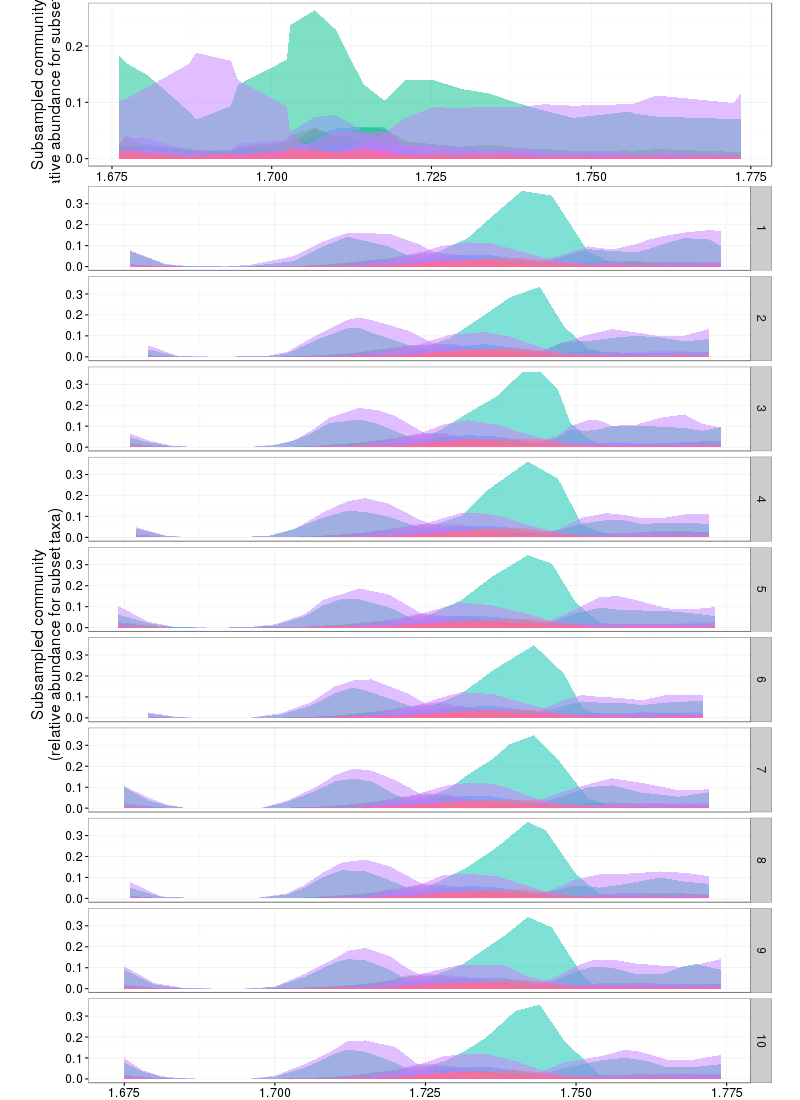

In [67]:
%%R -h 1100 -w 800

# cutoff on which OTU are major outliers (varying between simulated and emperical)
BD.diff.cut = 0.01

# which OTU to plot?
df.j.cm.s.f = df.j.cm.s %>% 
    mutate(cm_diff = abs(emperical - simulated)) %>%
    #filter(cm_diff <= BD.diff.cut, ! is.na(simulated),
    filter(
           emperical < 1.72,
           simulated > 1.73) 

print('OTUs:')
print(df.j.cm.s.f$OTU)

# filtering to just target taxon
## Simulated
df.j.f = df.j %>%
    filter(dataset == 'simulated', 
           OTU %in% df.j.cm.s.f$OTU) 

p.SIM = plot_abunds(df.j.f)
p.SIM = p.SIM + facet_grid(SIM_rep ~ .)

## Emperical
df.j.f = df.j %>%
    filter(dataset == 'emperical', 
           OTU %in% df.j.cm.s.f$OTU)
p.EMP = plot_abunds(df.j.f)

# make figure
grid.arrange(p.EMP, p.SIM, ncol=1, heights=c(1,5))

## Plotting abundances of some outlier taxa

* why is simulated so different in center of mass vs emperical?

[1] "OTUs:"
 [1] "OTU.106"  "OTU.113"  "OTU.119"  "OTU.121"  "OTU.1275" "OTU.146" 
 [7] "OTU.149"  "OTU.15"   "OTU.18"   "OTU.224"  "OTU.226"  "OTU.264" 
[13] "OTU.270"  "OTU.2746" "OTU.2978" "OTU.3"    "OTU.31"   "OTU.32"  
[19] "OTU.3380" "OTU.3382" "OTU.34"   "OTU.3492" "OTU.36"   "OTU.382" 
[25] "OTU.394"  "OTU.403"  "OTU.4057" "OTU.44"   "OTU.462"  "OTU.50"  
[31] "OTU.649"  "OTU.717"  "OTU.75"   "OTU.79"   "OTU.8"    "OTU.84"  
[37] "OTU.87"   "OTU.9"   


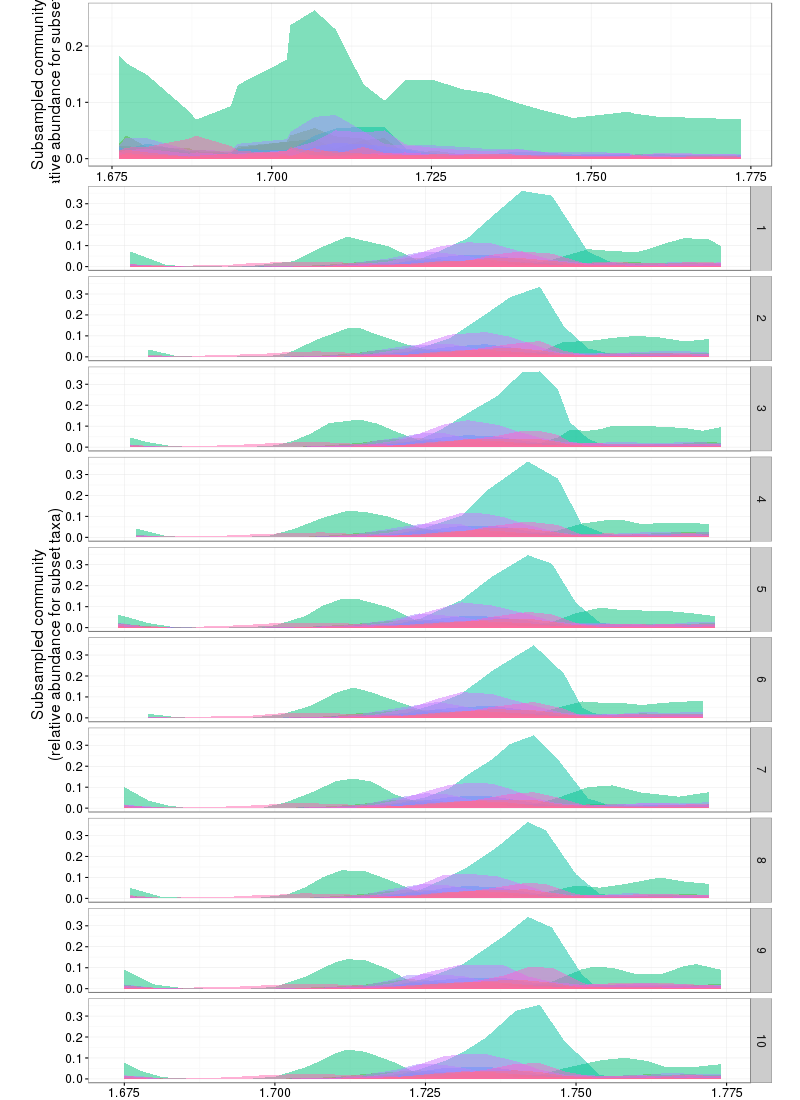

In [49]:
%%R -h 1100 -w 800

# cutoff on which OTU are major outliers (varying between simulated and emperical)
BD.diff.cut = 0.02

# which OTU to plot?
df.j.cm.s.f = df.j.cm.s %>% 
    mutate(cm_diff = abs(emperical - simulated)) %>%
    filter(cm_diff > BD.diff.cut, ! is.na(simulated)) 

print('OTUs:')
print(df.j.cm.s.f$OTU)

# filtering to just target taxon
## Simulated
df.j.f = df.j %>%
    filter(dataset == 'simulated', 
           OTU %in% df.j.cm.s.f$OTU) 

p.SIM = plot_abunds(df.j.f)
p.SIM = p.SIM + facet_grid(SIM_rep ~ .)

## Emperical
df.j.f = df.j %>%
    filter(dataset == 'emperical', 
           OTU %in% df.j.cm.s.f$OTU)
p.EMP = plot_abunds(df.j.f)

# make figure
grid.arrange(p.EMP, p.SIM, ncol=1, heights=c(1,5))

#### Notes

* The center of mass seems to be correct: most taxa are shifted heavier relative to the emperical data

### Check: which taxon is the highly abundant one?

* why is it shifted so far to 'heavy'
* the abundance distribution mode is ~1.73, which is a G+C of ~0.71


**Abundant taxon: OTU.32**
  * rep genome: Pseudonocardia_dioxanivorans_CB1190.fna
    * genome GC = 73.31
    * do the G+C contents of this amplicon region vary among taxa in the genus?
    * No, genome G+C for all 7 genomes in ncbi are ~70 

### Check: plotting 'absolute' abudance distributions for major CM outliers

In [50]:
%%R
# subset outliers
df.SIM.abs.t = df.SIM.abs %>%
    filter(taxon %in% df.target$OTU) %>%
    group_by(SIM_rep, fraction) %>%
    mutate(rel_abund_c = count / sum(count)) %>%
    rename('Buoyant_density' = BD_mid,
           'OTU' = taxon) %>%
    filter(OTU %in% df.j.cm.s.f$OTU) 

df.SIM.abs.t %>% head(n=3) %>% as.data.frame

  library     OTU    fraction BD_min Buoyant_density BD_max count    rel_abund
1       1 OTU.106  -inf-1.660   -Inf           1.659  1.659    48 0.0007544916
2       1 OTU.106 1.660-1.664  1.660           1.662  1.664    30 0.0011098369
3       1 OTU.106 1.664-1.669  1.664           1.667  1.669    58 0.0015808122
                                                                                   SIM_rep
1 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/7
2 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/7
3 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_rep10_justOverlap/7
   rel_abund_c
1 0.0007544916
2 0.0011098369
3 0.0015808122


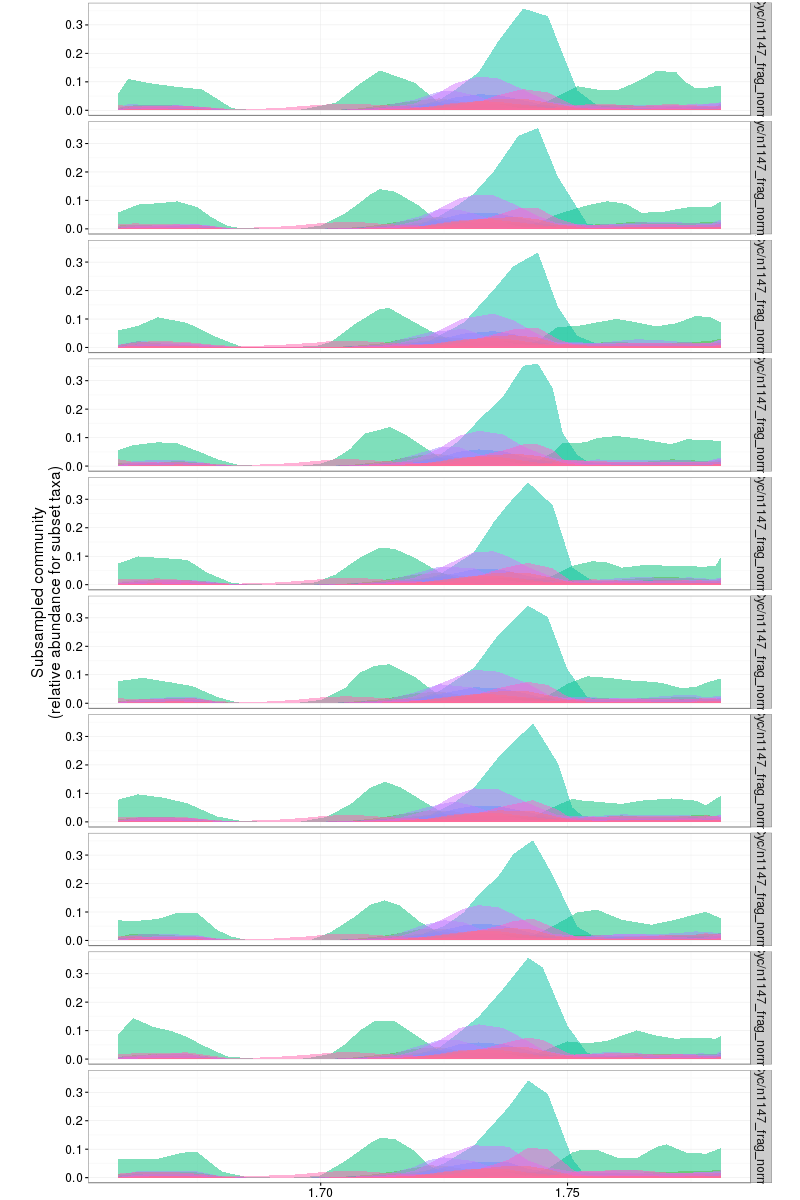

In [51]:
%%R -w 800 -h 1200
# plotting
p.abs = plot_abunds(df.SIM.abs.t) 
p.abs + facet_grid(SIM_rep ~ .)

#### Notes:

* simulated absolute abundances seem similar to the simulated relative abundances: both shifted heavy vs emperical

### What genomes are these outliers?

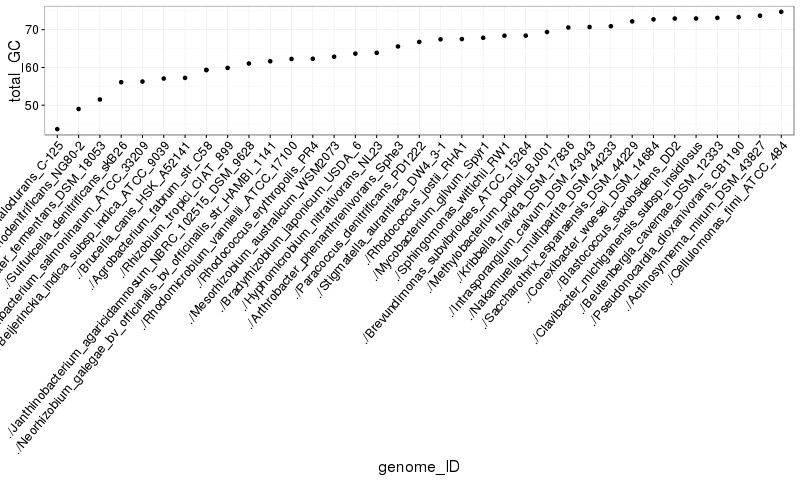

In [52]:
%%R -w 800
genomes = df.target %>% 
    filter(OTU %in% df.SIM.abs.t$OTU) 

df.genInfo = read.delim('/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/genome_info.txt')
df.genInfo.f = df.genInfo %>% 
    filter(seq_name %in% genomes$genome_seqID) %>%
    mutate(genome_ID = gsub('\\.fna', '', file_name))

df.genInfo.f$genome_ID = reorder(df.genInfo.f$genome_ID, df.genInfo.f$total_GC)

# plotting
ggplot(df.genInfo.f, aes(genome_ID, total_GC)) +
    geom_point() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=50, hjust=1)
    )

#### Notes

* Odd... these outlier OTUs are simulated from genomes with high G+C.
  * I would have expected the OTUs to be shifted right in the emperical data.
  * Are the simulations over-shifting the distributions of heavy G+C taxa?

### Plotting rep genome G+C of all overlapping taxa

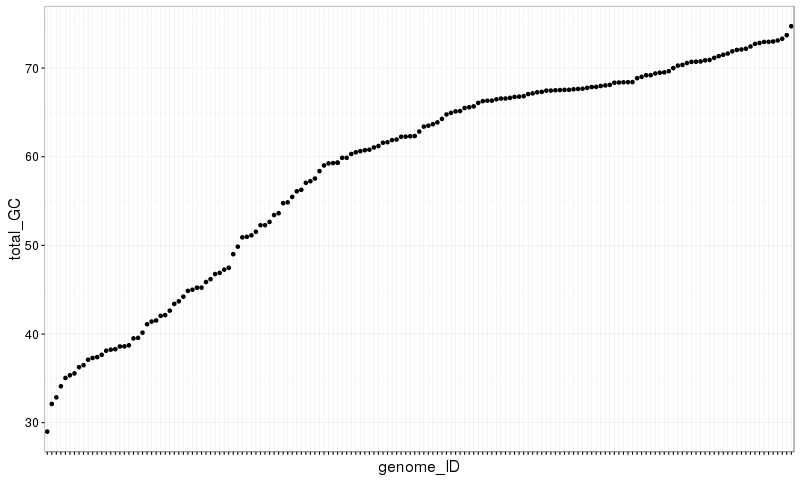

In [53]:
%%R -w 800

df.genInfo = read.delim('/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/genome_info.txt')
df.genInfo.f = df.genInfo %>% 
    filter(seq_name %in% df.target$genome_seqID) %>%
    mutate(genome_ID = gsub('\\.fna', '', file_name))

df.genInfo.f$genome_ID = reorder(df.genInfo.f$genome_ID, df.genInfo.f$total_GC)

# plotting
ggplot(df.genInfo.f, aes(genome_ID, total_GC)) +
    geom_point() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
    )